#  Grappa.ai - Run AI based recon in Gadgetron

Welcome to the Grappa.ai demo. This demo is developed as a part of [Gadgetron](https://github.com/gadgetron/gadgetron) ISMRM 2019 software demo session.

This demo is to show you how to implement an AI based MR reconstruction model and deploy it into Gadgetron recon chain. 

This example (I call it **Grappa.ai**) aims to demonstrate how to write a python function to implemant a MR recon with [PyTorch](https://pytorch.org/) and call the recon inside a Gadgetron chain.

**Author**: `Hui Xue <hui.xue@nih.gov>`

**National Heart Lung and Blood Institute (NHLBI),**
**National Institutes of Health,**
**Bethesda, Maryland, US**


### Import Pytorch and other libraries

To install Pytorch:
```
sudo pip3 install https://download.pytorch.org/whl/cpu/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl
sudo pip3 install torchvision
```

or if you have GPU:
```
sudo pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl
```

To install ismrmrd python and ismrmrd python-tool:
```
cd ~/software
git clone git@github.com:ismrmrd/ismrmrd-python.git
cd ismrmrd-python
sudo python3 setup.py install

git clone git@github.com:ismrmrd/ismrmrd-python-tools.git
cd ismrmrd-python-tools
sudo python3 setup.py install
```

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

import os
import sys
import time
import numpy as np
import scipy as sp
import scipy.io as spio
import copy

import ismrmrd
import ismrmrdtools
from ismrmrdtools import show, simulation, transform
from ismrmrdtools import coils

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Determine whether we have GPU

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")

using device: cuda


### Get environment variables for Gadgetron

This demo requires the installation of Gadgetron. The enviornment variable **GADGETRON_HOME** points to the directory where Gadgetron is installed.
The Gadgetron python path should be added to Python sys search path.

In [3]:
# get Gadgetron home
gt_home = os.getenv('GADGETRON_HOME')
print("Gadgetron is installed at ", gt_home)

# get Gadgetron folder for python scripts
gt_py_home = os.path.join(gt_home, 'share/gadgetron/python')
print("Gadgetron Python scripts are installed at ", gt_py_home)

# insert Gadgetron python folder to python sys path
sys.path.insert(0, gt_py_home)

# path to store test data
gt_data_home = os.path.join(os.getcwd(), 'data')
print("Test data is at ", gt_data_home)

Gadgetron is installed at  /home/xueh2/local
Gadgetron Python scripts are installed at  /home/xueh2/local/share/gadgetron/python
Test data is at  /home/xueh2/mrprogs/ISMRM2019_demo/AI_in_Gadgetron/data


### Useful functions for AI MR Recon

In [4]:
def complex_2_real(a):
    """
    Convert a data matrix from complex to real and imag array
    """
    a_r = np.real(a)
    a_i = np.imag(a)

    D, NA = a_r.shape

    res = np.zeros((D, 2*NA), dtype=np.float32)

    res[:,0:NA] = a_r
    res[:,NA:] = a_i
    
    return res

def real_2_complex(a):
    """
    Convert a real and imag data matrix to complex
    """
    D, NA = a.shape

    N = int(NA/2)
    
    res = a[:,0:N] + 1j * a[:,N:]
    
    return res

In [5]:
def plot_image_array(im, columns=4, figsize=[32, 32], cmap='gray'):
    """Plot image array as a panel of images
    """
    fig=plt.figure(figsize=figsize)
    plt.set_cmap(cmap)
    
    if(len(im.shape)==3):
        RO, E1, N = im.shape
    else:
        RO, E1 = im.shape
        N = 1

    rows = np.ceil(N/columns)
    for i in range(1, N+1):
        fig.add_subplot(rows, columns, i)
        if(len(im.shape)==3):
            plt.imshow(im[:,:,i-1])
        else:
            plt.imshow(im)
    plt.show()
    
    return fig

## Load kspace data

This test data is a phantom scan with R=3 acceleration. The matrix size 192x144 with 75% phase encoding resolution. THe readout is SSFP and ACE/ref data is 192x48.

In [6]:
print(os.getcwd())
data_dir = os.path.join(gt_data_home, 'meas_MID00349_FID09273_SNR_R3')
data_name = os.path.join(data_dir, 'Grappa_test_data.mat')
print(data_name)
D = spio.loadmat(data_name)
accelFactor = 3

/home/xueh2/mrprogs/ISMRM2019_demo/AI_in_Gadgetron
/home/xueh2/mrprogs/ISMRM2019_demo/AI_in_Gadgetron/data/meas_MID00349_FID09273_SNR_R3/Grappa_test_data.mat


In [7]:
ref_src = np.squeeze(D['ref_src'])
ref_dst = np.squeeze(D['ref_dst'])
data = np.squeeze(D['data'])

In [8]:
print('ref_src = ', ref_src.shape, np.linalg.norm(ref_src))
print('ref_dst = ', ref_dst.shape, np.linalg.norm(ref_dst))
print('data = ', data.shape, np.linalg.norm(data))

refRO, refE1, dstCHA = np.squeeze(ref_dst).shape

ref_src =  (192, 48, 14) 30475.879
ref_dst =  (192, 48, 8) 30304.547
data =  (192, 144, 14) 18690.494


### Plot the data

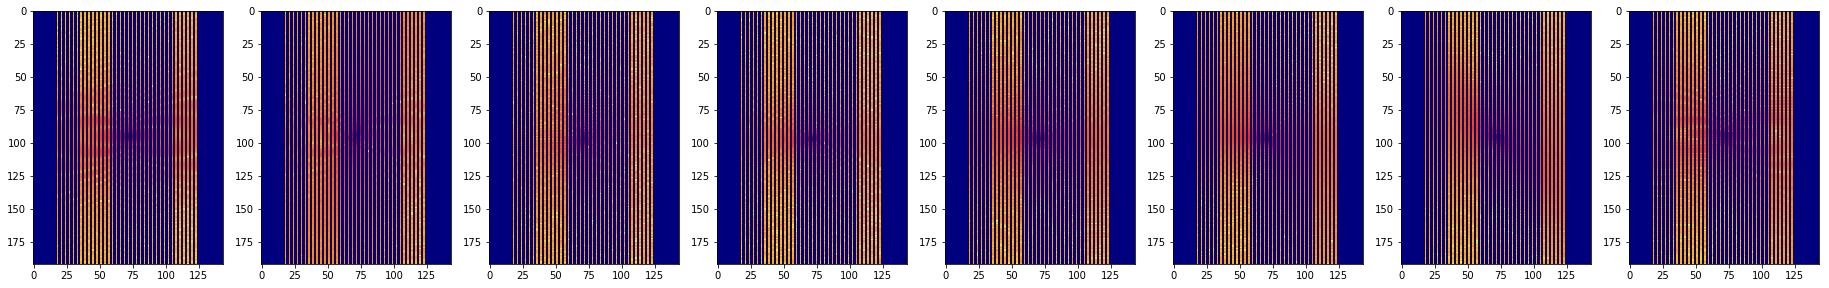

In [9]:
# plot data for first 8 channels
res = plot_image_array(np.log(np.abs(data[:,:,0:8])+1e-8), 8, [32,32], cmap='jet')

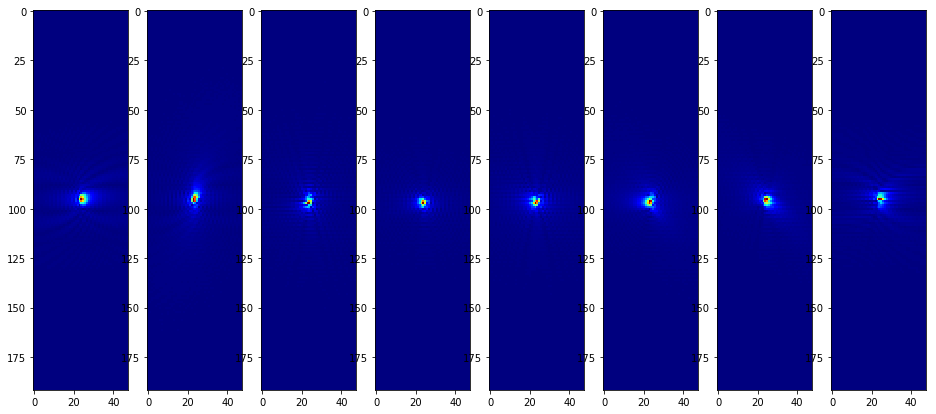

In [10]:
# plot ACS data for first 8 channels
res = plot_image_array(np.abs(ref_src[:,:,0:8]), 8, [16, 16], cmap='jet')

## Grappa recon

Let's first perform a Grappa reconstruction by calling the Gadgetron python wrapper for Grappa:

This python wrapper is declared at ${GADGETRON_DIR}\toolboxes\mri_core\mri_core_grappa_python.h, which uses the [boost-python](https://www.boost.org/doc/libs/1_69_0/libs/python/doc/html/index.html) to wrap c++ functionality.

Recall Grappa is to estimate kspace interpolation kernel to fill in unacquired phase encoding line: ![Grappa calibration process!](images/Grappa.png)

All red points are acquired kspace data. These points are fitted to blud dots (missing data). For a kernel size of 5x4, the Grappa calibration equation can be assembled.

After solving this linear system, the kernel is estimated from ACS data. Applying the kernel to imaging data is just another matrix multiplication.

In [12]:
# Let's import Gadgetron grappa
import gadgetron_toolbox_mri_core_python as gt

In [13]:
grappa = gt.grappa2D()

kRO = 5 # kernel size along RO
kNE1 = 4 # kernel size along first phase encoding
fitItself = False # whether to fix green dot
thres = 1e-4 # regularization for matrix inversion

res = grappa.initialize(accelFactor, kRO, kNE1, fitItself, thres)

In [14]:
if(fitItself):
    grappa.calib(ref_src, ref_dst)    
else:
    grappa.calib(ref_src, ref_src)

In [15]:
try:
    data2D = data[:,:,:,0]
    fullkspace = grappa.recon(data[:,:,:,0], True)
except:
    fullkspace = grappa.recon(data, True)
    data2D = data
    
print("Reconstructed full kspace is ", fullkspace.shape)

if(not fitItself):
    fullkspace = fullkspace + data2D

# convert to image domain
im = transform.transform_kspace_to_image(fullkspace)

# estimate coil map
(csm_est2, rho2) = coils.calculate_csm_inati_iter(np.transpose(im, (2,0,1)))
csm = np.transpose(csm_est2, (1,2,0))

# coil combination
im_combined = np.sum(im*np.conj(csm), axis=2)

Reconstructed full kspace is  (192, 144, 14)


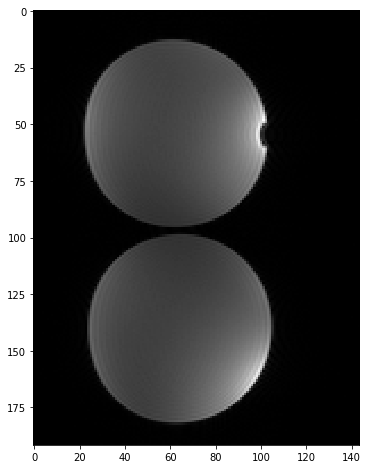

In [16]:
res = plot_image_array(np.abs(im_combined), 1, [8, 8])

## Run Grappa reconstruction as numpy matrix multiplication

The reconstrution process of Grappa is as follows:

```
for every kspace point in data:
    1. Extract the 5x4xCHA acquired dataA
    2. Multiply dataA with ker : res = np.dot(dataA, ker)
        here ker is (5x4xCHA, 2xCHA)
        res is (1, 2xCHA)
    3. Fill res to the data array for missing data
```

In practise, we should assamble the dataA as a matrix (N, 5x4xCHA) and perform the matrix multiplication once.

Gadgetron python grappa offers functions to return dataA.

In [17]:
# calibration matrix A
A = grappa.get_A()
# calibration matrix A
B = grappa.get_B()
# estimated kernel
ker = grappa.get_ker()
print('A is ', A.shape)
print('B is ', B.shape)
print('ker is ', ker.shape)

dataA = grappa.get_data_A()
dataAInd = grappa.get_data_A_index()

print('dataA = ', dataA.shape)
print('dataAInd = ', dataAInd.shape)

A is  (7332, 280)
B is  (7332, 28)
ker is  (5, 4, 14, 14, 2)
dataA =  (6912, 280)
dataAInd =  (6912, 2)


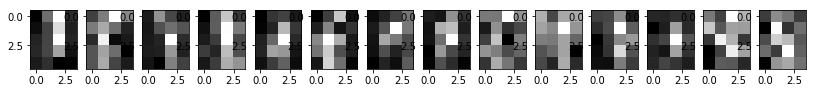

In [19]:
# plot kernel, how do they look?
res = plot_image_array(np.abs(ker[:,:,:,4,1]), 32, [32,32])

In [20]:
# let's flat kernel array to (kROxkNE1xCHA, oE1xCHA)
kRO, kNE1, srcCHA, dstCHA, oE1 = ker.shape
ker_2D = np.reshape(ker, (kRO*kNE1*srcCHA, dstCHA*oE1), order='F')
print(ker_2D.shape)

(280, 28)


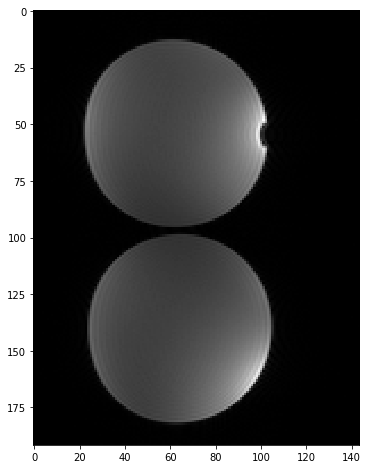

In [21]:
# let's do the grappa recon by matrix multiplication
RO = data.shape[0]
E1 = data.shape[1]
# grappa recon here!
recon = np.dot(dataA, ker_2D)

# fill the recon back to original kspace to fill missing dots
res = grappa.recon_fill_back_kspace(recon, dataAInd, RO, E1)
if (not fitItself):
    res = np.add(res, data2D)

# get the image
im = transform.transform_kspace_to_image(res)
im_combined = np.sum(im*np.conj(csm), axis=2)
res = plot_image_array(np.abs(im_combined), 1, [8, 8])

## Run Grappa Recon as a NN

First to remember, PyTorch does not support complex data type yet, so we need to modify Grappa recon process accordingly:
![Grappa Recon as a NN!](images/GrappaNN.jpg)

The real and imag parts of Grappa kernel are extracted and torch.nn.Linear layers are initliazed with Grappa weights. The reconstruction thus consists of two linear layers and add/subtract operations

In [22]:
A_r = np.real(A)
A_i = np.imag(A)

ker_2D_r = np.real(ker_2D)
ker_2D_i = np.imag(ker_2D)

dataA_r = np.real(dataA)
dataA_i = np.imag(dataA)

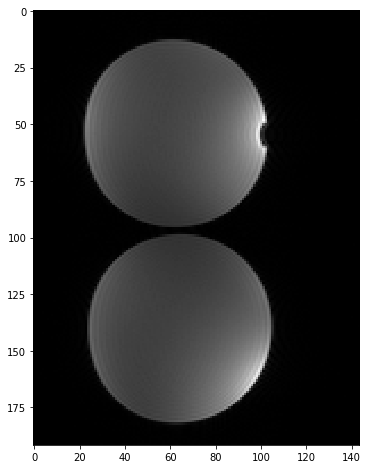

In [23]:
# Prove the concepts

_, Din = A.shape
_, H0 = B.shape

with_bias = False
input_layer_r = torch.nn.Linear(int(Din), int(H0), bias=with_bias)
input_layer_i = torch.nn.Linear(int(Din), int(H0), bias=with_bias)

input_layer_r.weight.data = torch.from_numpy(np.transpose(ker_2D_r, (1,0)))
input_layer_i.weight.data = torch.from_numpy(np.transpose(ker_2D_i, (1,0)))

r_r = input_layer_r(torch.from_numpy(dataA_r))
i_i = input_layer_i(torch.from_numpy(dataA_i))
r_i = input_layer_r(torch.from_numpy(dataA_i))
i_r = input_layer_i(torch.from_numpy(dataA_r))

C_r = r_r - i_i
C_i = r_i + i_r

recon = C_r.detach().numpy() + 1j * C_i.detach().numpy()

res = grappa.recon_fill_back_kspace(recon, dataAInd, RO, E1)
if (not fitItself):
    res = np.add(res, data2D)

# get the image
im = transform.transform_kspace_to_image(res)
im_combined = np.sum(im*np.conj(csm), axis=2)
res = plot_image_array(np.abs(im_combined), 1, [8, 8])

## Let's write a grappa recon NN

In [24]:
class GrappaAI(nn.Module):
    def __init__(self, Din, Dout, params):
        
        super(GrappaAI, self).__init__()

        self.verbose = params['verbose']
        self.with_bias = False
        self.grappa_weights_r = params['grappa_weights_r']
        self.grappa_weights_i = params['grappa_weights_i']
        
        # for real and imag
        self.input_layer_r = torch.nn.Linear(int(Din/2), int(Dout/2), bias=self.with_bias)
        self.input_layer_i = torch.nn.Linear(int(Din/2), int(Dout/2), bias=self.with_bias)

        if self.verbose:
            print("    GrappaAI : input size (%d), output size (%d), with bias %s" % (Din, Dout, self.with_bias))

        print("---> Set grappa weights")
        self.input_layer_r.weight.data = self.grappa_weights_r
        self.input_layer_i.weight.data = self.grappa_weights_i
                
    def forward(self, x):

        # split x to real and img
        M, N = x.shape

        N_h = int(N/2)

        x_r = x[:, 0:N_h]
        x_i = x[:, N_h:N]

        r_r = self.input_layer_r(x_r)
        i_i = self.input_layer_i(x_i)

        r_i = self.input_layer_r(x_i)
        i_r = self.input_layer_i(x_r)

        res_r = r_r - i_i
        res_i = r_i + i_r

        out = torch.cat([res_r, res_i], dim=1)

        return out

In [25]:
params = dict()

params['verbose'] = True
params['grappa_weights_r'] = torch.from_numpy(np.transpose(ker_2D_r, (1,0))).to(torch.float32)
params['grappa_weights_i'] = torch.from_numpy(np.transpose(ker_2D_i, (1,0))).to(torch.float32)
       
# for real and imag parts
Din = 2*A.shape[1]
Dout = 2*B.shape[1]

model = GrappaAI(Din, Dout, params)

    GrappaAI : input size (560), output size (56), with bias False
---> Set grappa weights


dataA for NN is  (6912, 560)
Recon after NN is  (6912, 28)


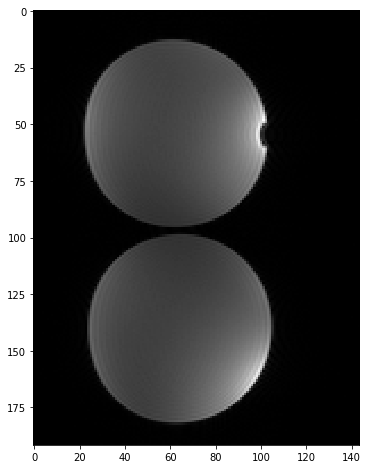

In [26]:
# apply to dataA
dataA_NN = complex_2_real(dataA)
print("dataA for NN is ", dataA_NN.shape)

dataA_NN = torch.from_numpy(dataA_NN)
dataA_NN = dataA_NN.to(torch.float32)

recon_NN = model(dataA_NN)

recon = recon_NN.detach().cpu().numpy()
recon = real_2_complex(recon)
print("Recon after NN is ", recon.shape)

res = grappa.recon_fill_back_kspace(recon, dataAInd, RO, E1)
if (not fitItself):
    res = np.add(res, data2D)

# get the image
im = transform.transform_kspace_to_image(res)
im_combined = np.sum(im*np.conj(csm), axis=2)
res = plot_image_array(np.abs(im_combined), 1, [8, 8])

## Call Grappa.ai in Gadgetron

In [29]:
%%bash
gadgetron_ismrmrd_client -f ./data/meas_MID00349_FID09273_SNR_R3/meas_MID00349_FID09273_SNR_R3.h5 -c Generic_Cartesian_Grappa_AI.xml -a localhost -p 9002 -G grappa_ai -o ./data/meas_MID00349_FID09273_SNR_R3/grappa_ai_res.h5

Gadgetron ISMRMRD client
  -- host            :      localhost
  -- port            :      9002
  -- hdf5 file  in   :      ./data/meas_MID00349_FID09273_SNR_R3/meas_MID00349_FID09273_SNR_R3.h5
  -- hdf5 group in   :      /dataset
  -- conf            :      Generic_Cartesian_Grappa_AI.xml
  -- loop            :      1
  -- hdf5 file out   :      ./data/meas_MID00349_FID09273_SNR_R3/grappa_ai_res.h5
  -- hdf5 group out  :      grappa_ai
This measurement has dependent measurements
  SenMap : 45387_1079885_1079904_343
  Noise : 45387_1079885_1079904_343
Querying the Gadgetron instance for the dependent measurement: 45387_1079885_1079904_343
Noise level: Min sigma = 3.50739e-06, Mean sigma = 6.09193e-05, Max sigma = 6.08e-06


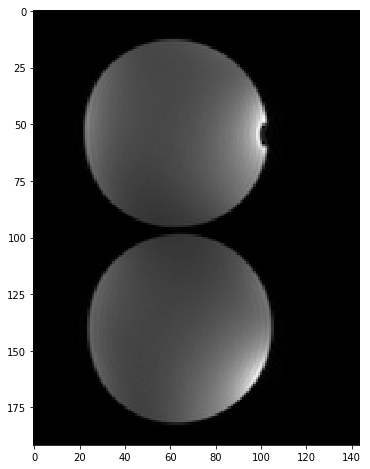

In [51]:
# check grappa.ai recon
import h5py
f = h5py.File('./data/meas_MID00349_FID09273_SNR_R3/grappa_ai_res.h5', 'r')
im_ai = f.get('grappa_ai/image_2/data')
im_ai = np.squeeze(im_ai).T
res = plot_image_array(np.abs(im_ai), 1, [8, 8])